In [1]:
import os
import glob
import uproot
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams.update({"figure.facecolor": (1,1,1,0)})
import mplhep as hep
plt.style.use(hep.style.CMS)
import yahist
from tqdm import tqdm

from utils.file_info import parse

PLOTDIR = "/home/users/jguiang/public_html/vbsvvhjets_plots/xsecs"
BASEDIR = "../analysis/studies/vbsvvhjets"
TAG = "abcdnet_v3"

os.makedirs(PLOTDIR, exist_ok=True)

YEAR = "RunIISummer20UL18"
SIM_VER = "v2"
CEPH_DIR = "/ceph/cms/store/user/jguiang/VBSVVHSignalGeneration"

In [2]:
def plot_xsecs(VVH=None, c2v_points=None, xsecs=None, axes=None, fit_guess=[0, 0, 0]): # VVH = WZH, ZZH, WWH_OS, or WWH_SS
    if not (VVH is None):
        print(f"Plotting {VVH}")
        # Get names of reweighting schemes
        with open("../analysis/data/VBSVVH_reweights.txt", "r") as f_in:
            reweight_names = f_in.read().splitlines()

        # Get reweighting weights
        root_file = f"{CEPH_DIR}/{SIM_VER}/VBS{VVH}_VBSCuts_TuneCP5_{YEAR}-106X_privateMC_NANOGEN_{SIM_VER}/merged.root"
        with uproot.open(root_file) as f:
            reweights = np.stack(f["Events"].arrays("LHEReweightingWeight", library="np")["LHEReweightingWeight"])
            # Insert trivial weight
            reweights = np.insert(reweights, 28, 1, axis=1)
            # Interpret reweights matrix shape
            n_events, n_reweights = reweights.shape

        # Get file info
        finfo = parse(root_file, xsecs_json="../analysis/data/xsecs.json")

    if xsecs is None:
        # Get list of C2V points and compute xsecs
        c2v_points = []
        xsecs = []
        for reweight_i in range(reweights.T.shape[0]):
            name = reweight_names[reweight_i]

            xsec = finfo["xsec_sf"]*np.sum(reweights.T[reweight_i])/(1000*finfo["lumi"])
            xsecs.append(xsec)

            c2v = float(name.split("_")[4].replace("m", "-").replace("p", "."))
            c2v_points.append(c2v)
    elif c2v_points is None:
        raise Exception("Error: xsecs provided, but c2v_points not provided!")
        return

    # Perform fit
    parabola = lambda x, A, B, C: A*x**2 + B*x + C
    opt_params, _ = curve_fit(parabola, c2v_points, xsecs, p0=fit_guess)
    A, B, C = opt_params

    # Plot fit and points
    if axes is None:
        fig, axes = plt.subplots();

    # Plot fit
    axes.plot(
        np.linspace(-3, 5, 41), [parabola(x, A, B, C) for x in np.linspace(-3, 5, 41)], 
        color="#00629B",
        linestyle="dashed",
        label=(r"$Ac_{2V}^2 Bc_{2V} C$".replace("A", f"{A:0.3f}")
                                       .replace("B", f"{B:+0.3f}")
                                       .replace("C", f"{C:+0.3f}"))
    );
    # Plot reweighted xsecs
    axes.scatter(
        c2v_points, xsecs, 
        marker="o", 
        color="#00629B",
        label=r"Reweighted $\sigma$", 
        zorder=100
    );
    
    # Add legend
    axes.legend();

    # Add CMS label
    hep.cms.label(
        "Preliminary",
        data=False,
        loc=0,
        ax=axes,
    )

    axes.set_ylim(bottom=0)
    axes.set_xlabel(r"$c_{2V}$");
    axes.set_ylabel(r"$\sigma$ [pb]");
    if not (VVH is None):
        axes.text(0.98, 0.02, f"VBS {VVH.replace('_', ' ')}", ha="right", transform=axes.transAxes)
        
    if VVH is None:
        plt.savefig(f"{PLOTDIR}/xsecs.png")
    else:
        plt.savefig(f"{PLOTDIR}/{VVH}_xsecs.png")
    
    return axes, xsecs, c2v_points

Plotting WWH_OS
Plotting WWH_SS
Plotting WZH
Plotting ZZH


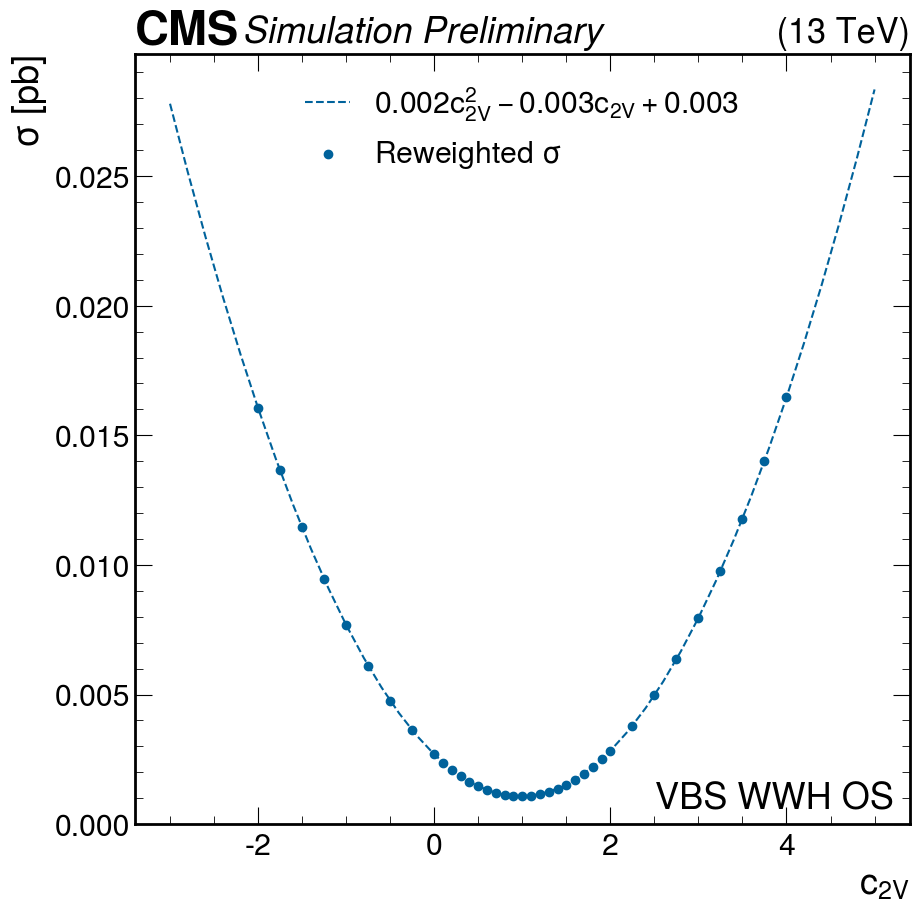

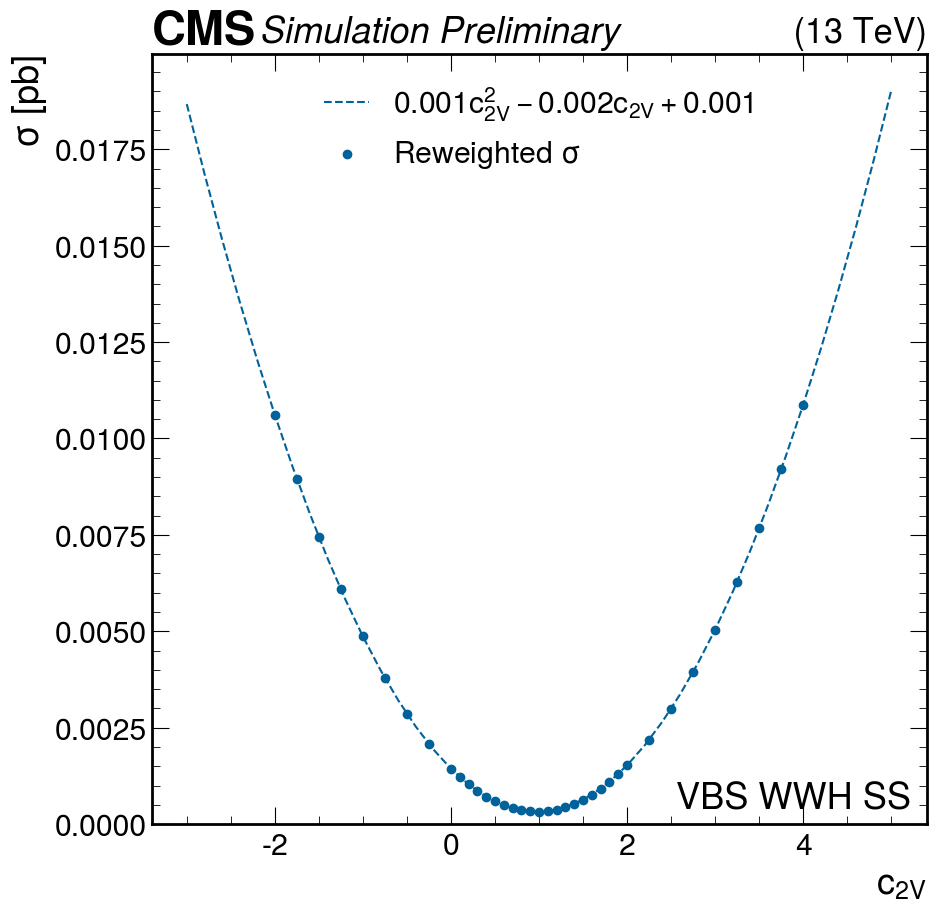

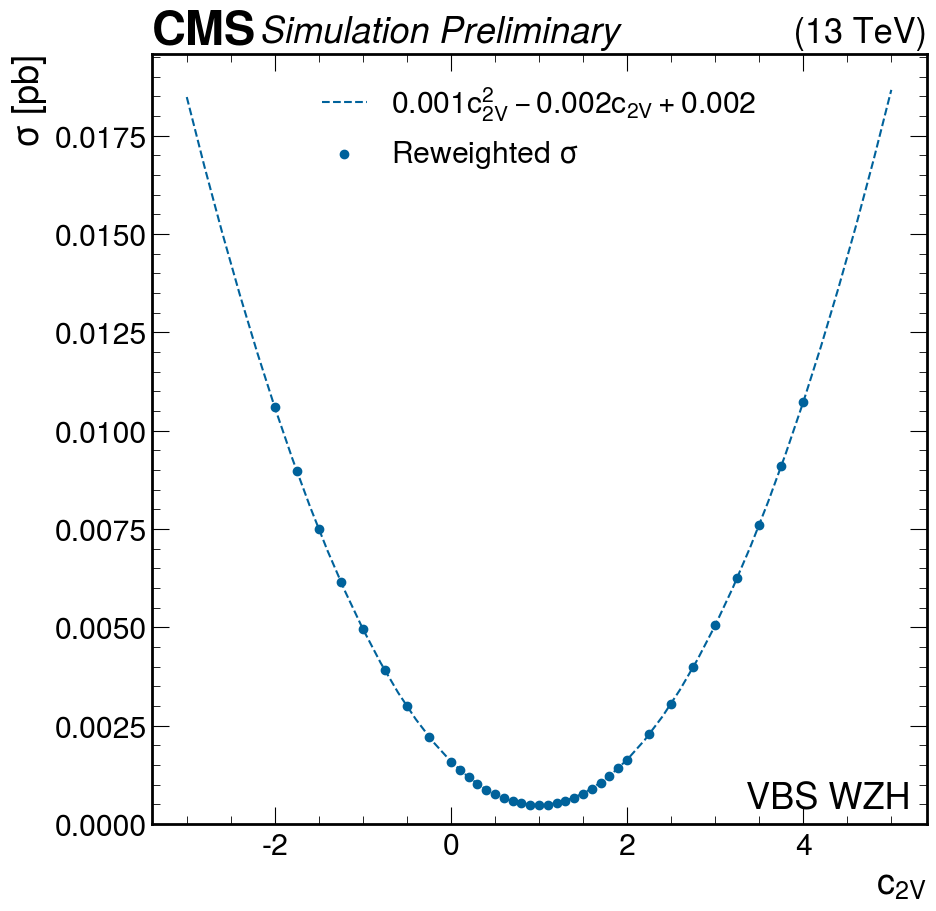

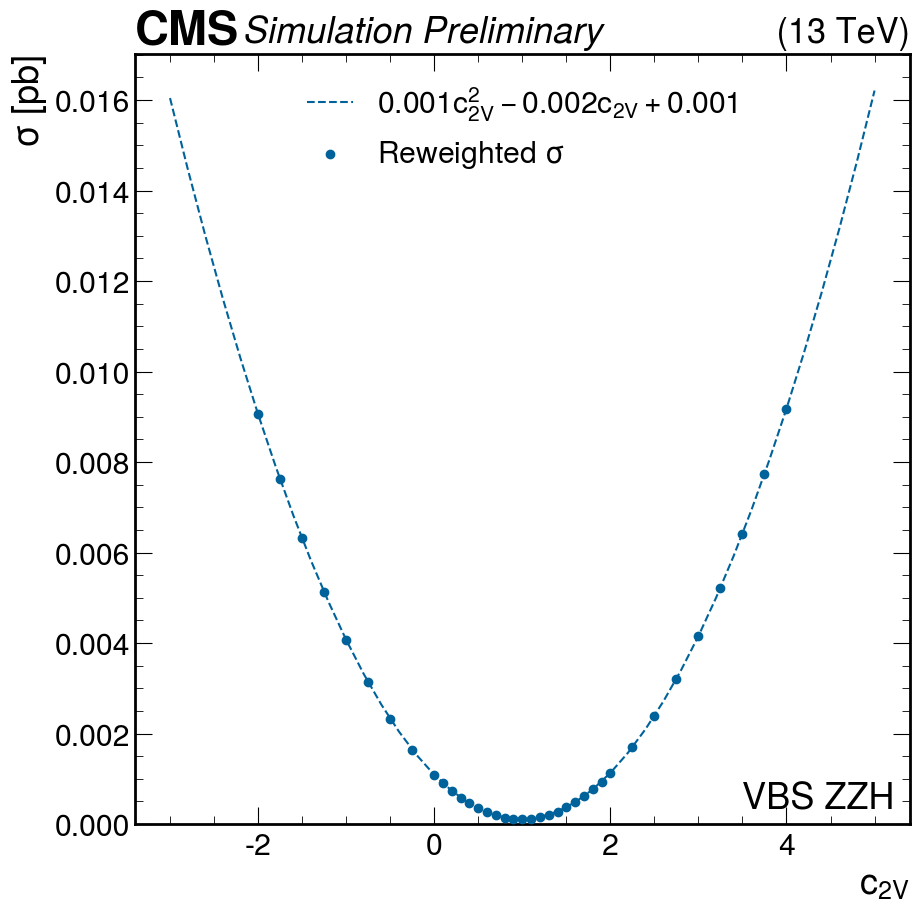

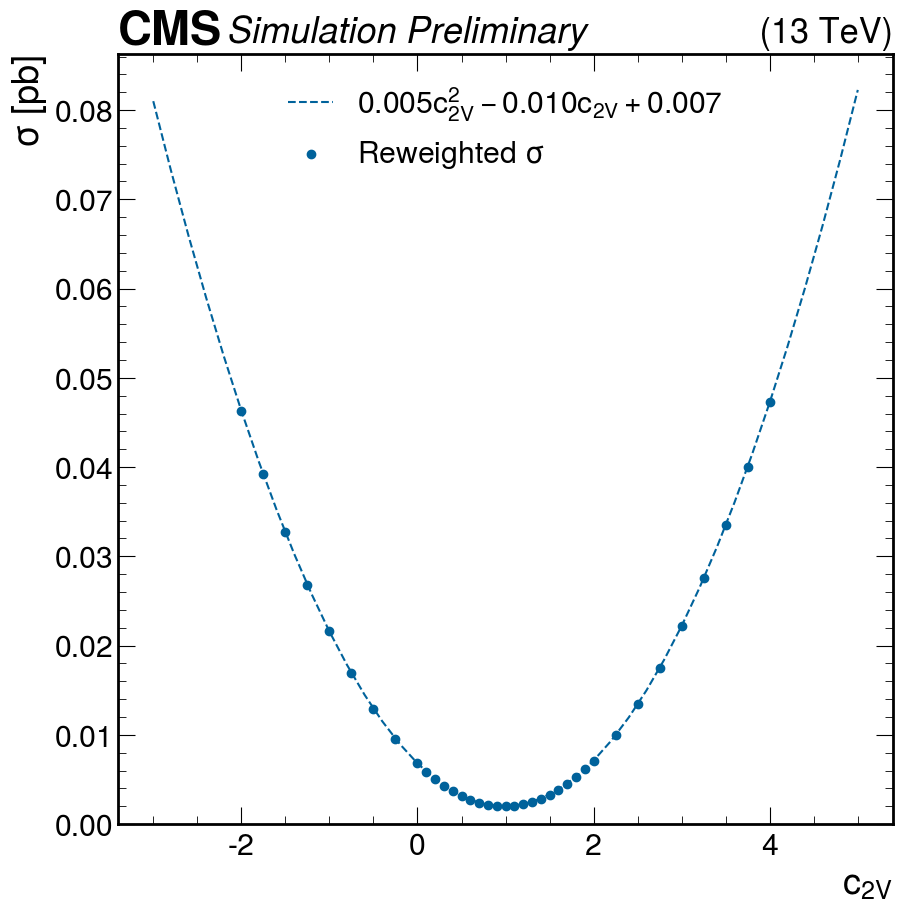

In [3]:
wwh_os_axes, wwh_os_xsecs, c2v_points = plot_xsecs(VVH="WWH_OS")
wwh_ss_axes, wwh_ss_xsecs, c2v_points = plot_xsecs(VVH="WWH_SS")
wzh_axes, wzh_xsecs, c2v_points = plot_xsecs(VVH="WZH")
zzh_axes, zzh_xsecs, c2v_points = plot_xsecs(VVH="ZZH")

vvh_xsecs = [sum(xsecs) for xsecs in zip(wwh_os_xsecs, wwh_ss_xsecs, wzh_xsecs, zzh_xsecs)]
plot_xsecs(xsecs=vvh_xsecs, c2v_points=c2v_points);

In [4]:
for xsecs, vvh in zip([wwh_os_xsecs, wwh_ss_xsecs, wzh_xsecs, zzh_xsecs, vvh_xsecs], ["WWH_OS", "WWH_SS", "WZH", "ZZH", None]):
    if vvh is None:
        csv_file = f"{PLOTDIR}/xsecs.csv"
    else:
        csv_file = f"{PLOTDIR}/{vvh}_xsecs.csv"
        
    with open(csv_file, "w") as f:
        f.write("c2v,xsec\n")
        for xsec, c2v in zip(xsecs, c2v_points):
            f.write(f"{c2v},{xsec}\n")
    
    with open(csv_file.replace(".csv", ".txt"), "w") as f:
        f.write("  c2v,        xsec\n")
        for xsec, c2v in zip(xsecs, c2v_points):
            f.write(f"{c2v:>5},{xsec:>12.9f}\n")